In [1]:
import pandas as pd
import seaborn as sns

import os
os.environ.setdefault("DARTS_CONFIGURE_MATPLOTLIB", "0")
from darts import TimeSeries    
import matplotlib.pyplot as plt
    
from darts.models import BlockRNNModel
from darts.metrics import mape, mae, rmse
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("./data/amf-performance.csv")
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
df = df.drop(['time', 'lat75', 'lat80', 'lat90', 'lat95', 'lat98', 'lat99', 'lat100'], axis=1)

frequency = '1h'

# additional features
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

# Remove from ram_limit 'M' and convert the column to integer
df['ram_limit'] = df['ram_limit'].str.replace('M', '').astype(int)

df_max = df.resample(frequency, on='datetime').max()
df_max

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-10 14:00:00,2048.0,2.0,1.130758e+09,1.276808,500.0,60398090.0,60414274.0,10.0,14.0
2021-11-10 15:00:00,2048.0,2.0,1.559351e+09,0.996645,460.0,93936583.0,94259814.0,10.0,15.0
2021-11-10 16:00:00,2048.0,2.0,1.494233e+09,0.983066,480.0,95931083.0,96020918.0,10.0,16.0
2021-11-10 17:00:00,2048.0,2.0,1.600532e+09,0.983279,480.0,97132575.0,97360300.0,10.0,17.0
2021-11-10 18:00:00,2048.0,2.0,1.010856e+09,0.999460,440.0,97207925.0,97417298.0,10.0,18.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


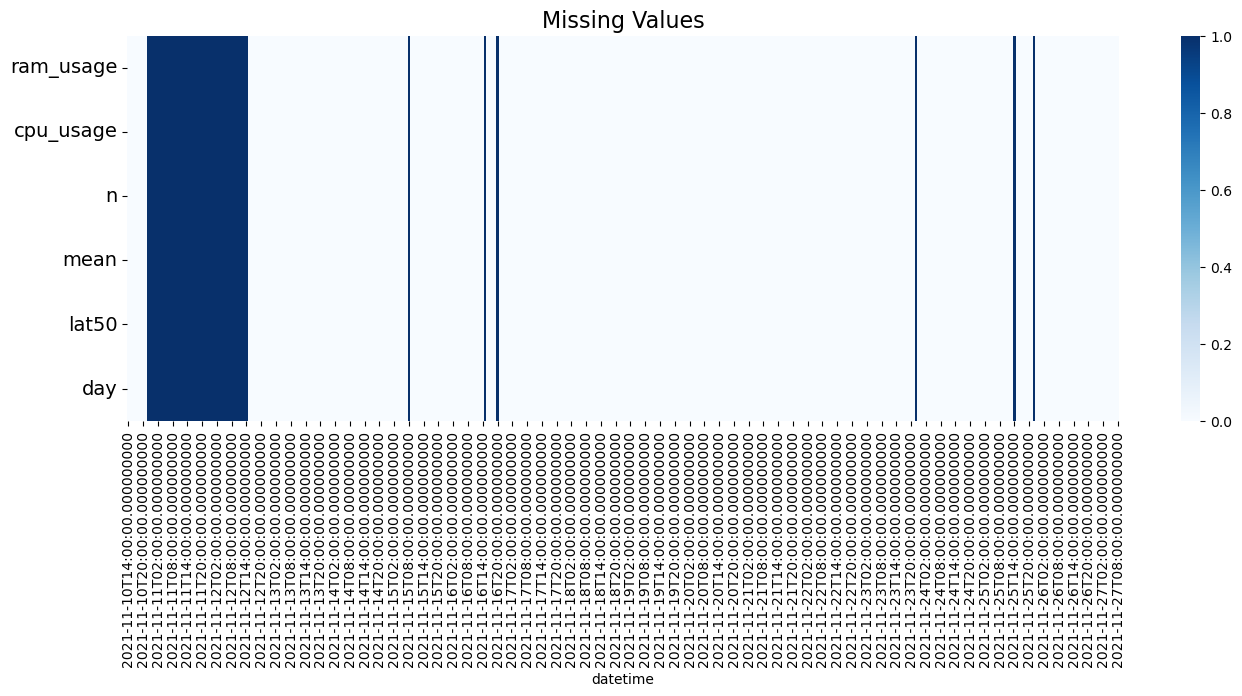

In [3]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_max.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Remove the big portion of missing values

In [4]:
# Set the filter condition based on the desired date and time
df_max_reset = df_max.reset_index()
df_max_reset['datetime'] = pd.to_datetime(df_max_reset['datetime'])
filter_condition = df_max_reset['datetime'] > '2021-11-12 14:00:00'

# Apply the filter to get the subset of the DataFrame
filtered_df = df_max_reset[filter_condition].set_index('datetime')

Plot filtered datafarame

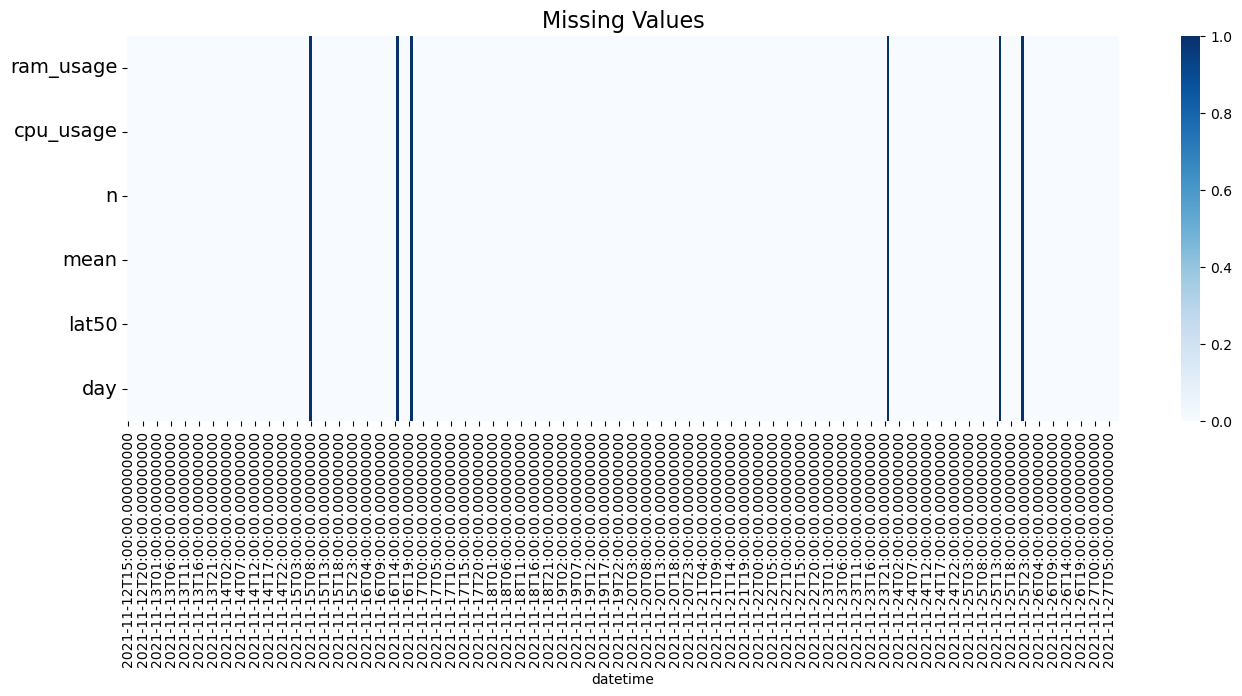

In [5]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(filtered_df.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Interpolate in order to fill the null values in the df

In [6]:
interpolated_df = filtered_df.interpolate()
interpolated_df.isna().sum()

ram_limit    0
cpu_limit    0
ram_usage    0
cpu_usage    0
n            0
mean         0
lat50        0
day          0
hour         0
dtype: int64

In [7]:
interpolated_df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1.203683e+09,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1.870483e+09,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1.847726e+09,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1.854063e+09,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1.766617e+09,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


# Gated Recurrent Unit (GRU) forecasting

In [8]:
# define train and test size
train_size = int(0.7 * len(interpolated_df))
test_size = len(interpolated_df) - train_size

split_point = interpolated_df.iloc[train_size].name
split_point

Timestamp('2021-11-22 22:00:00')

In [9]:
series = TimeSeries.from_dataframe(interpolated_df.reset_index(), 'datetime', ['cpu_usage'])

# train test split
train, test = series.split_after(split_point)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(test)
series_transformed = transformer.transform(series)

In [10]:
# define early stopping parameters
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0009,
    mode='min',
)

# Define learning rate scheduler
lr_scheduler_config = {
    "scheduler": StepLR,  # Example: StepLR decreases LR by a factor every few epochs
    "step_size": 25,      # Decrease LR every 25 epochs
    "gamma": 0.1,         # LR decay factor
}

# Define learning rate monitor callback (optional but useful for visualization)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

pl_trainer_kwargs={"callbacks": [my_stopper], "log_every_n_steps": 5}

# build model
my_model = BlockRNNModel(
    model="GRU",
    hidden_dim=20,
    dropout=0,
    batch_size=8,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-2},
    model_name="GRU_forecast_cpu",
    log_tensorboard=True,
    random_state=42,
    input_chunk_length=5,
    output_chunk_length=1,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
    #lr_scheduler_cls=lr_scheduler_config["scheduler"],
    #lr_scheduler_kwargs={
    #    "step_size": lr_scheduler_config["step_size"],
    #    "gamma": lr_scheduler_config["gamma"]
    #},
)

# train model
my_model.fit(
    train_transformed,
    val_series=val_transformed,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 1.4 K 
4 | fc            | Sequential       | 21    
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |                                                                                      | 0/? …

Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=20, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0, batch_size=8, n_epochs=100, optimizer_kwargs={'lr': 0.01}, model_name=GRU_forecast_cpu, log_tensorboard=True, random_state=42, input_chunk_length=5, output_chunk_length=1, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000018618686310>], 'log_every_n_steps': 5})

In [11]:
series_transformed.time_index[train_size - 4:train_size + 1]

DatetimeIndex(['2021-11-22 18:00:00', '2021-11-22 19:00:00',
               '2021-11-22 20:00:00', '2021-11-22 21:00:00',
               '2021-11-22 22:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')

In [12]:
val_transformed.time_index[0]

Timestamp('2021-11-22 23:00:00')

In [13]:
best_model = BlockRNNModel.load_from_checkpoint(model_name="GRU_forecast_cpu", best=True)

pred_series = best_model.historical_forecasts(
    series_transformed[train_size- my_model.input_chunk_length + 1:],
    start = val_transformed.time_index[0],
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                           | 0/? …

In [14]:
len(pred_series)

106

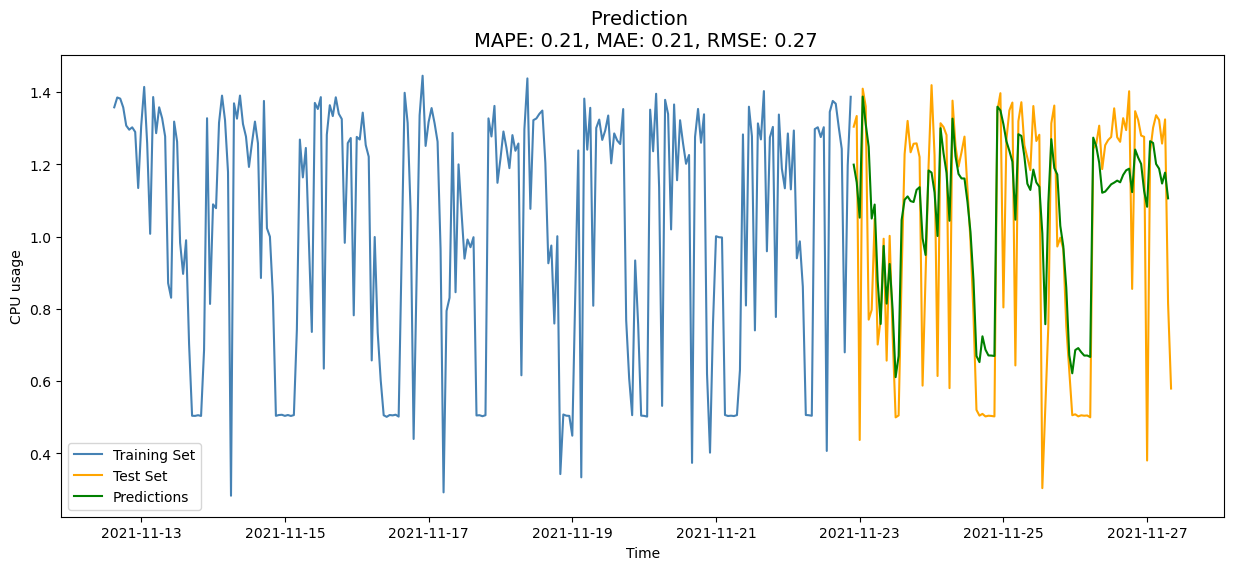

In [15]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

pred_series_inverse = transformer.inverse_transform(pred_series)


mape_score = mape(pred_series_inverse, test)/100
mae_score = mae(pred_series_inverse, test)
rmse_score = rmse(pred_series_inverse, test)

pred_series_ravel = pred_series_inverse.values().ravel()

# Plot the data
ax.plot(interpolated_df.index[:train_size], series[:train_size].values(), label="Training Set", color="steelblue")
ax.plot(interpolated_df.index[train_size:], series[train_size:].values(), label="Test Set", color="orange")
ax.plot(interpolated_df.index[train_size:-1], pred_series_ravel, label="Predictions", color='green')
plt.title(f'Prediction \n MAPE: {mape_score:.2f}, MAE: {mae_score:.2f}, RMSE: {rmse_score:.2f}', fontsize=14)

plt.xlabel('Time')
plt.ylabel('CPU usage') 
plt.legend()

plt.show()